## This notebook explores learned policies from the policies agents:

In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc

import os
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow_lattice as tfl

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



Using TensorFlow backend.


In [2]:
name = 'DDQNPER'
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
logs = os.listdir(log_path)
logs

['20200703-155551']

In [3]:
log_num = -1
models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
actions_bins = np.load(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'action_bins.npy'))
model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
try:
    buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
except:
    print('No buffer found.')
    
with open(buffer_path,'rb') as f:
    buffer = pickle.load(f)

In [4]:
os.listdir(model_path)

['action_bins.npy', 'buffer.pkl', 'main_net.h5']

In [5]:
# actions_bins = np.array([0, 0.1, 1])
# actions_bins = np.array([0, 0.2])
# actions_bins = np.array([0, 0.5])
n_actions = len(actions_bins)
c_env = CollectionsEnv(continuous_reward=False)
environment = DiscretizedActionWrapper(c_env, actions_bins)
environment = StateNormalization(environment)

Setting
New action space: Discrete(2)


c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[INFO] [2020-07-08 15:08:24,888] [AAV] - Instantiated @ AAV
Train on 7200 samples, validate on 800 samples
Epoch 1/1000
7200/7200 [==============================] - 1s 139us/sample - loss: 9455.8831 - val_loss: 8817.7927
Epoch 2/1000
7200/7200 [==============================] - 0s 44us/sample - loss: 5392.7192 - val_loss: 3705.5025
Epoch 3/1000
7200/7200 [==============================] - 0s 44us/sample - loss: 1995.9407 - val_loss: 679.7694
Epoch 4/1000
7200/7200 [==============================] - 0s 45us/sample - loss: 377.4966 - val_loss: 45.4371
Epoch 5/1000
7200/7200 [==============================] - 0s 42us/sample - loss: 130.6754 - val_loss: 12.9083
Epoch 6/1000
7200/7200 [==============================] - 0s 42us/sample - loss: 115.6127 - val_loss: 13.4868
Epoch 7/1000
7200/7200 [==============================] - 0s 40us/sample - loss: 113.4000 - val_loss: 6.4551
Epoch 8/1000
7200/7200 [==============================] - 0s 37us/sample - loss: 112.1943 - val_loss: 5.1276
Epoch 

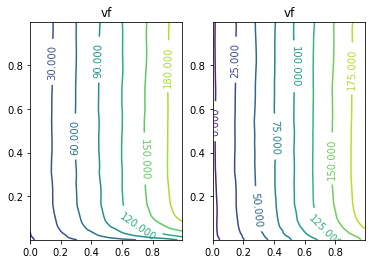

../..\learning\utils\construct_nn.py:95: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


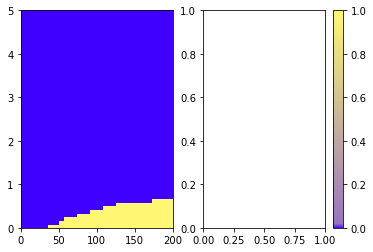

In [6]:
config = DefaultConfig()
agent = DQNAgent(environment, 'DDQN', training=False, config=DefaultConfig())
agent.load(model_path)

In [25]:
w_points = 120
l_points = 120

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

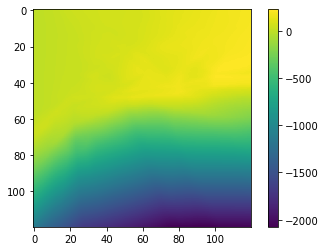

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(z)
fig.colorbar(im)

Text(0.5, 1.0, 'Simplest default with labels')

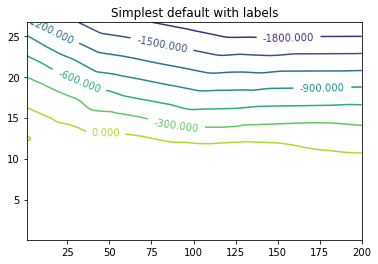

In [27]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

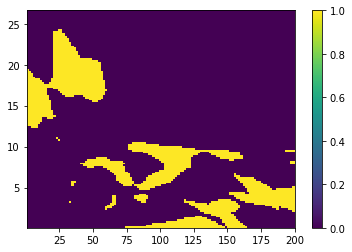

In [28]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

elementary check

In [29]:
fixed_obs = np.array([0.1, 100])
obs = environment.observation(fixed_obs)
agent.main_net.predict_on_batch(obs[None,:])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[78.65803, 81.09462]], dtype=float32)>

In [30]:
environment.observation((0.11,100))

array([3.76503815e-04, 4.95000000e-01])

In [31]:
w_points = 60
l_points = 60
lam_lim = 3
l = np.linspace(environment.observation_space.low[0], lam_lim, l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, environment.observation((3,100))[0], l_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

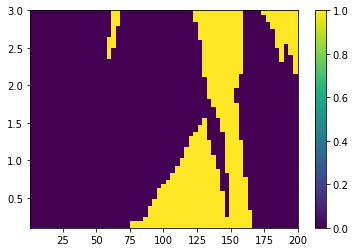

In [32]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Value function')

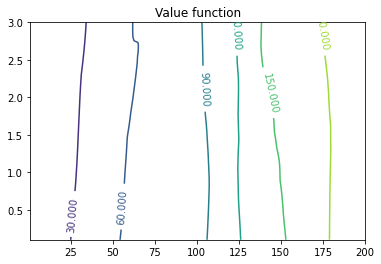

In [33]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')

[INFO] [2020-07-08 15:22:35,247] [AAV] - Instantiated @ AAV
[INFO] [2020-07-08 15:22:35,260] [OAV] - Launching the value function procedure.
[INFO] [2020-07-08 15:22:35,261] [OAV] - Computing the value function on (0.00, 16.83].
[INFO] [2020-07-08 15:22:35,266] [OAV] - Computing the value function on (16.83, 18.70].
[INFO] [2020-07-08 15:22:36,038] [OAV] - Computing the value function on (18.70, 20.78].
[INFO] [2020-07-08 15:22:36,659] [OAV] - Computing the value function on (20.78, 23.08].
[INFO] [2020-07-08 15:22:37,057] [OAV] - Computing the value function on (23.08, 25.65].
[INFO] [2020-07-08 15:22:37,318] [OAV] - Computing the value function on (25.65, 28.50].
[INFO] [2020-07-08 15:22:37,997] [OAV] - Computing the value function on (28.50, 31.66].
[INFO] [2020-07-08 15:22:38,222] [OAV] - Computing the value function on (31.66, 35.18].
[INFO] [2020-07-08 15:22:38,941] [OAV] - Computing the value function on (35.18, 39.09].
[INFO] [2020-07-08 15:22:39,510] [OAV] - Computing the valu

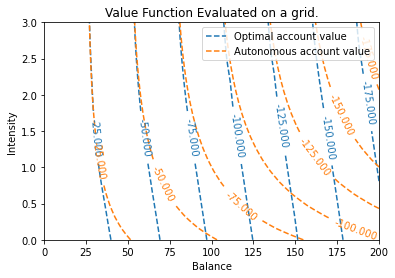

In [34]:
from dcc import OAV, Parameters, AAV
p = Parameters()
w_start = MAX_ACCOUNT_BALANCE
oav = OAV(p, w_start, lmax=3)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

In [35]:
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')

Text(0.5, 1.0, 'Value function')

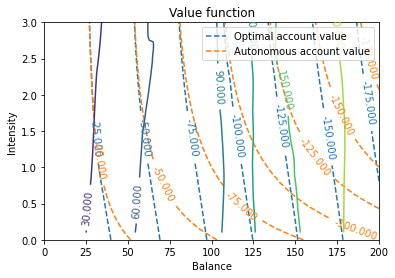

In [36]:
fig

## Exploration of statespace

In [18]:
import seaborn as sns 
visits = [environment.convert_back(trans.s) for trans in buffer]
visits_w = np.array([vis[1] for vis in visits])
visits_l = np.array([vis[0] for vis in visits])

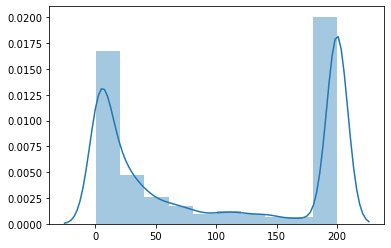

In [19]:
sns.distplot(visits_w, bins=10)

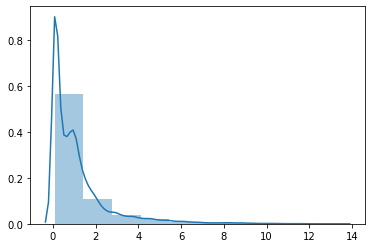

In [20]:
sns.distplot(visits_l, bins=10)

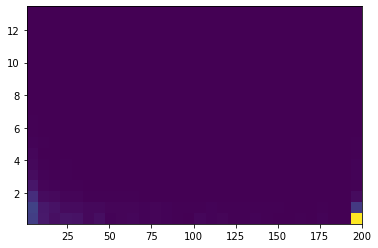

In [21]:

import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
mask = visits_w > 0

x = visits_w[mask]
y = visits_l[mask]

# fig,ax = plt.subplots(figsize=(10,10))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=(30,20))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', interpolation='nearest', aspect='auto')
# fig.show()

In [24]:
np.max(y)

13.4479265

In [ ]:
# from tqdm import tqdm
# from IPython.display import clear_output

# def create_value_map_policy(wpoints=60, lpoints=60):
#     llim = 3
#     # setup meshgrid
#     wgrid = np.linspace(agent.env.observation_space.low[1] , agent.env.observation_space.high[1], wpoints)
#     lgrid = np.linspace(agent.env.observation_space.low[0] , 3, lpoints)
    
#     w_normalized = np.linspace(0, 1, wpoints)
#     l_normalized = np.linspace(0, environment.observation((llim,100))[0], lpoints)
    
#     ww, ll = np.meshgrid(w_normalized, l_normalized)
#     vs = np.zeros_like(ww)
    
#     for i, xp in enumerate(tqdm(ww[0, :])):
#         for j, yp in enumerate(lln[:,0]):
#             agent.env.env.starting_state = np.array([yp, xp])
#             # agent.env.current_state = np.array([yp, xp])
#             vs[j, i] = np.mean(agent.evaluate(200))
#         clear_output(wait=True)
#     return ww, ll, vs
    
# wg, lg, wg = create_value_map_policy(wpoints=10, lpoints=10)

# lets value this policy:

In [405]:
rewards = agent.evaluate(500)

Avg. reward over 500 episodes: 105.1343


In [406]:
np.mean(rewards)

105.1343281011366

[INFO] [2020-06-25 21:53:56,052] [AAV] - Instantiated @ AAV


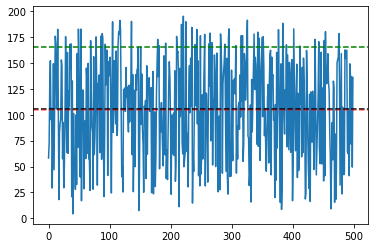

In [407]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, MAX_ACCOUNT_BALANCE), color='red', linestyle='--', alpha=0.5)
plt.axhline(-aav.u(4.5, MAX_ACCOUNT_BALANCE) - 4.5*p.c, color='green', linestyle='--')

In [408]:
np.mean(rewards)

105.1343281011366

In [409]:
u = -aav.u(0.11, MAX_ACCOUNT_BALANCE)

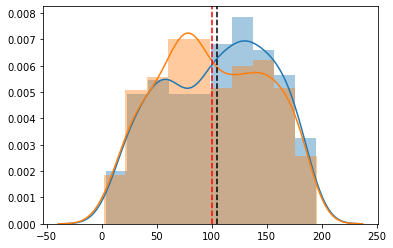

In [410]:
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(rewards, ax=ax, bins=10)
sns.distplot(rew_aav, ax=ax, bins=10)
ax.axvline(np.mean(rewards), color='black', linestyle='--')
ax.axvline(np.mean(rew_aav), color='red', linestyle='--')
#ax.axvline(u, color='green', linestyle='--')

In [ ]:
# agent.evaluate(100)

In [270]:
def sim():
    rewards = []
    w_states = []
    l_states = []
    actions = []
    for i in range(500):
        episode_reward = 0
        done = False
        state = environment.reset()
        while not done:
            # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
            #action, q = agent.get_action(state, epsilon=0.0)
            action = 0
            actions.append(action)
            state, reward, done, _ = environment.step(action)
            episode_reward += reward
            converted_state = environment.convert_back(state)
            w_states.append(converted_state[1])
            l_states.append(converted_state[0])
            if episode_reward>200:
                break
            if done:
                rewards.append(episode_reward)
    return rewards

rew_aav = sim()
        

[INFO] [2020-06-25 14:11:40,146] [AAV] - Instantiated @ AAV


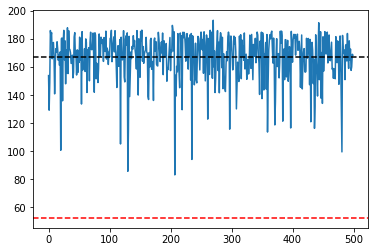

In [274]:
#plt.plot(results['REINFORCE AB'])
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

Statespace path

In [376]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        #action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if episode_reward>200:
            break
        if done:
            rewards.append(episode_reward)


In [377]:
l_states[0]

1.0752615

Text(0, 0.5, 'Intensity')

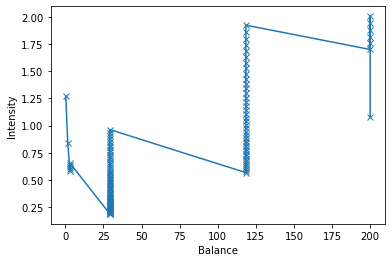

In [378]:
fig, ax = plt.subplots()
ax.plot(w_states, l_states, marker='x')
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')

Text(0, 0.5, 'Action size applied')

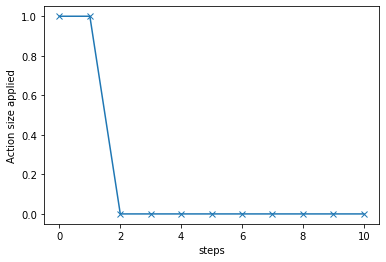

In [278]:
fig, ax = plt.subplots()
ax.plot(actions, marker='x')
ax.set_xlabel('steps')
ax.set_ylabel('Action size applied')

In [ ]:
plt.plot(rewards)

Test policy that separates linearly the statespace by y=x

In [ ]:
def dummy_policy(state):
    if state[1] > state[0]:
        return 0
    else:
        return 1

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1000):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        action = dummy_policy(state)
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if done:
            rewards.append(episode_reward)

In [ ]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

In [ ]:
w_points = 60
l_points = 60

w_normalized = np.linspace(0, 1, w_points)
l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w_normalized):
    for j, yp in enumerate(l_normalized):
        fixed_obs = np.array([yp, xp])
        z[j, i] = dummy_policy(fixed_obs)

In [ ]:
plt.pcolor(ww, ll,z)
plt.colorbar()
plt.show()

In [ ]:
plt.contour(ww, ll, p)

In [ ]:
fig, ax = plt.subplots()

CS = ax.contour(ww, ll, p, levels=actions_bins.shape[0])

ax.clabel(CS, CS.levels, inline=True)

In [ ]:
environment.observation((np.array([10, 100])))

In [ ]:
environment.action(np.argmax(agent.main_net.predict_on_batch(environment.observation((np.array([0, 40])))[None,:])))

In [ ]:
agent.main_net.predict_on_batch(environment.observation((np.array([10, 100])))[None,:])

Too large rewards

In [ ]:
for i in range(500):
    rewards = []
    w_states = []
    l_states = []
    actions = []
    running_rew = []
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        # action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        running_rew.append(reward)
        if done:
            rewards.append(episode_reward)
    if episode_reward > 100:
            break
print(episode_reward)

In [ ]:
plt.plot(running_rew)

In [ ]:
sum(running_rew)

In [ ]:
plt.plot(w_states, l_states, marker='x')

In [ ]:
running_rew

In [ ]:
model5K.layer1.keras_api.call_and_return_all_conditional_losses(obs)

In [ ]:
tf.keras.models.load_model('dqn_5000e')